The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


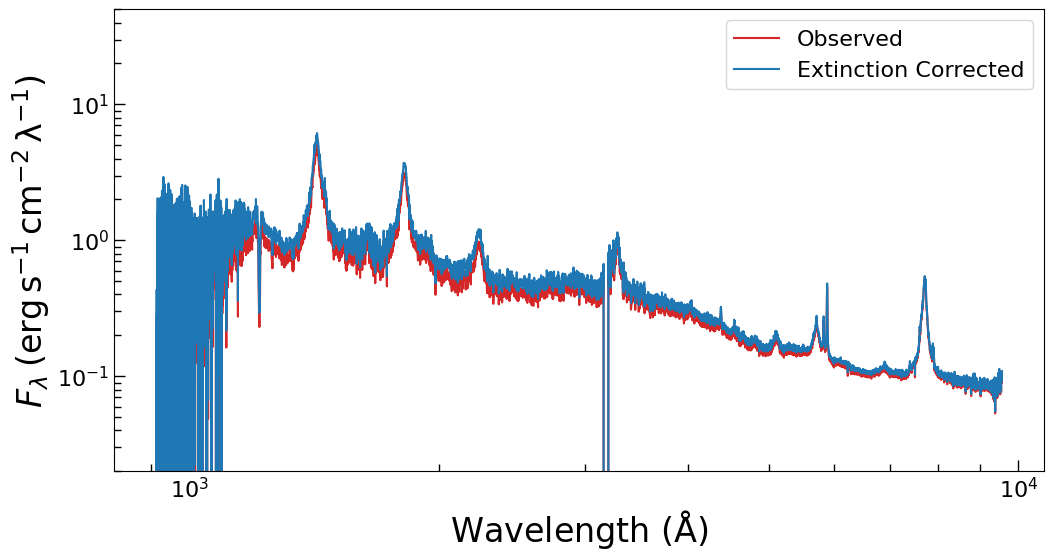

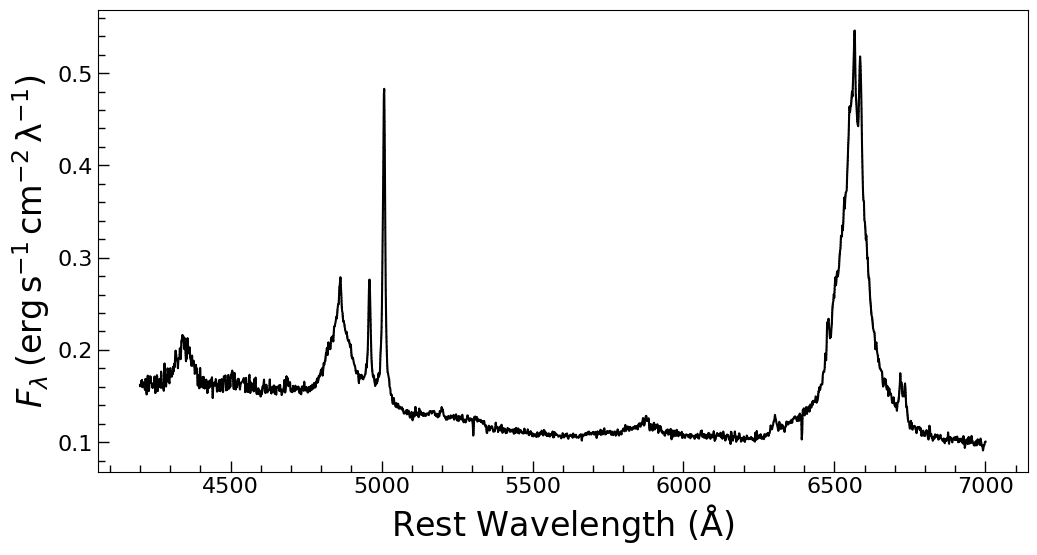

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg2349sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.075    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.1740 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

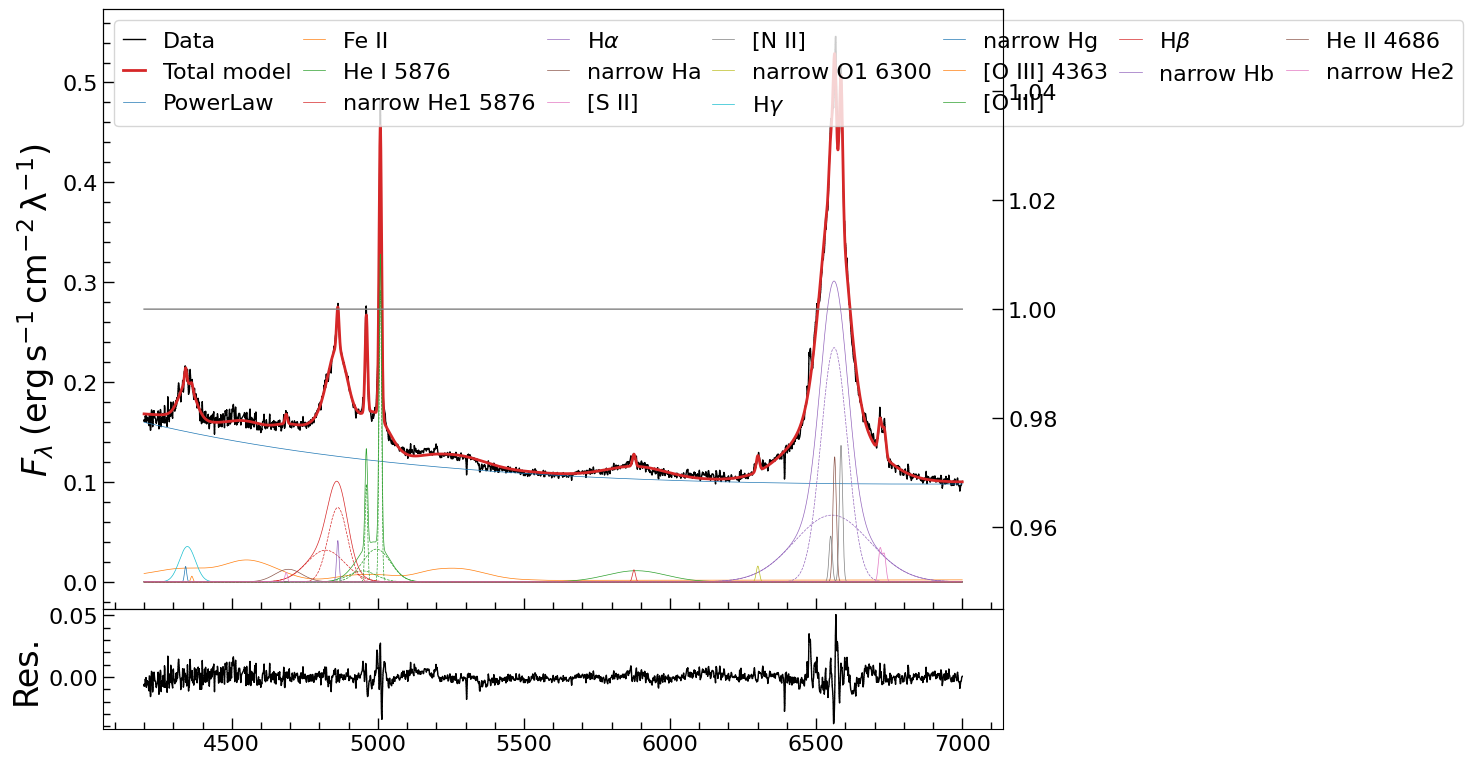

<PowerLaw1D(amplitude=0.05508865, x_0=5500., alpha=1.62918538, name='PowerLaw')>
<IronTemplate(amplitude=0.01968473, stddev=4102.913, z=0., name='Fe II')>
<Line_MultiGauss(amp_c=0.00535867, dv_c=352.81710566, sigma_c=5181.87411077, wavec=5875.624, name='He I 5876')>
<Line_Gaussian(amplitude=0.0058124, dv=17.83150115, sigma=261.38534624, wavec=5876., name='narrow He1 5876')>
<Line_MultiGauss(amp_c=0.09853151, dv_c=-82.45515885, sigma_c=2070.22301056, wavec=6562.819, amp_w0=0.28551023, dv_w0=-473.55207566, sigma_w0=5856.78523037, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.05258604, dv=17.83150115, sigma=261.38534624, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss_doublet(amp_c0=0.01334853, amp_c1=0.01095813, dv_c=17.83150115, sigma_c=261.38534624, wavec0=6718.29, wavec1=6732.68, name='[S II]')>
<Line_MultiGauss_doublet(amp_c0=0.05712262, amp_c1=0.01929818, dv_c=71.31470393, sigma_c=255.59722273, wavec0=6583.46, wavec1=6548.05, name='[N II]')>
<Line_Gaussian(amplitude=0.00702786,

In [28]:
#------------------------------------------------------------具体拟合，修改各成分
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
poly = models.Polynomial1D(degree=2, name='multi')  # The name must be `multi`; no more than 5th order
pl = models.PowerLaw1D(amplitude=0.05508865, x_0=5500, alpha=1.62918538, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')
'''from astropy.modeling import models, fitting, Fittable1DModel, Parameter
class PiecewisePowerLaw(Fittable1DModel):
    amplitude1 = Parameter(default=0.104)
    x_01 = Parameter(default=6100, fixed=True)
    alpha1 = Parameter(default=0.29)
    amplitude2 = Parameter(default=0.11)
    x_02 = Parameter(default=5450, fixed=True)
    alpha2 = Parameter(default=1.518)

    @staticmethod
    def evaluate(x, amplitude1, x_01, alpha1, amplitude2, x_02, alpha2):
        pl1 = amplitude1 * (x / x_01) **(-alpha1)
        pl2 = amplitude2 * (x / x_02) ** (-alpha2)
        return np.where(x > 5600, pl1, pl2)
pl = PiecewisePowerLaw()'''


iron = sagan.IronTemplate(amplitude=0.01968473, stddev=4102.913, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.229, dv_c=-96, sigma_c=2070, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.289, dv_w0=-140, sigma_w0=5556)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.0427, dv_c=462, sigma_c=2234, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.044, dv_c=-23.66, sigma_c=1567, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=1.34, dv_w0=-132, sigma_w0=3000, bounds=bounds)
'''
#b_ha = sagan.Line_MultiGauss(n_components=1, amp_c=2.22, dv_c=300, sigma_c=830, 
#                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'])
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.27, dv_c=540, sigma_c=1000, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.12, dv_w0=-630, sigma_w0=6900)

# It took me quite some time to adjust the 

#b_hb = sagan.Line_MultiGauss(n_components=1, amp_c=0.8, dv_c=-28, sigma_c=1000, 
#                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'])
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.12, dv_c=77, sigma_c=1200, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.2, dv_w0=235, sigma_w0=3000, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.059, dv_c=210, sigma_c=1350, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
'''

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.013, dv_c=-190, sigma_c=2539, wavec=5875.624, name='He I 5876')
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.038, amp_c1=0.032,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.15, amp_c1=0.05, dv_c=107, sigma_c=220,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')
##line_o3 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.32, amp_c1=0.1, dv_c=-10, sigma_c=350, 
##                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]')
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.2945, amp_c1=0.098, dv_c=-1.26, sigma_c=240, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.13, dv_w0=91.7, sigma_w0=1738)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01156, dv_c=500, sigma_c=2580, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
'''
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=-500, sigma_c=4000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.015, dv_c=-900, sigma_c=900, wavec=5875.624, name='He I 5876')  # Masked

#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=1.8, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.35, dv_w0=-280, sigma_w0=340)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=3, amp_c0=0.1, amp_c1=0.03, dv_c=50, sigma_c=210, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=0.35, dv_w0=-1300, sigma_w0=380, amp_w1=0.05, dv_w1=2000, sigma_w1=1000)
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.009, amp_c1=0.01,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')

# Usually we need [N II] 6548, 6583, but I cannot get a non-zero value for this doublet for this target
#line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=0.3, dv_c=-20, sigma_c=200,
#                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')
'''

n_ha = sagan.Line_Gaussian(amplitude=0.13, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_o1_6300 = sagan.Line_Gaussian(amplitude=0.013, wavec=6300, name=f'narrow O1 6300')
n_he1_5876 = sagan.Line_Gaussian(amplitude=0.00785, wavec=5876, name=f'narrow He1 5876')
n_hg = sagan.Line_Gaussian(amplitude=0.015, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.0077, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
n_hb = sagan.Line_Gaussian(amplitude=0.017, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_he2 = sagan.Line_Gaussian(amplitude=0.0086, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
'''
n_ha = sagan.Line_Gaussian(amplitude=0.07, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.017, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_hg = sagan.Line_Gaussian(amplitude=0.0067, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_he2 = sagan.Line_Gaussian(amplitude=0.006, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.01, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')
'''

line_he1 =  b_he1 + n_he1_5876
line_ha  =  b_ha + n_ha
line_hg  =  b_hg + n_hg
line_hb  =  b_hb + n_hb
line_he2 =  b_he2 + n_he2
'''
line_ha  =  b_ha + n_ha
line_hb  =  b_hb + n_hb
line_hg  =  b_hg + n_hg
line_he2 =  b_he2 + n_he2
line_he1 =  b_he1  # Masked
'''

m_init = (pl+iron+line_he1+ line_ha+ line_s2 +line_n2+n_o1_6300 + line_hg+ n_o3_4363+line_o3+line_hb+line_he2 )*poly
#+line_he1+ line_ha+ line_s2 +line_n2+n_o1_6300 + line_hg+ n_o3_4363+line_o3+line_hb+line_he2

def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

#def tie_n2(model):
#    return model['[N II]'].amp_c0 / 2.96
#line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
#line_n2.sigma_c.tied = tie_narrow_sigma
#line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_o1_6300,n_he1_5876]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 4409) & (wave_use < 4756)
fltr2= (wave_use > 5079) & (wave_use < 5348)
fltr11=(wave_use > 4260) & (wave_use < 4430)
fltr12=(wave_use > 4600) & (wave_use < 5120)
fltr13=(wave_use > 5550) & (wave_use < 6050)
fltr14=(wave_use > 6200) & (wave_use < 6890)
fltr15=(wave_use > 7010) & (wave_use < 7500)

#weights[fltr1] = 0.0
#weights[fltr2] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0
#weights[fltr15] = 0.0

#pl_values=pl(wave_use)# ------------------fix the power_law
#flux_use1=flux_use-pl_values
m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())